In [1]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append('../../lib')

import numpy as np

import LinOT
from LinOT.Visualization import *
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

# Visualize all samples to get an idea of dataset
* have variation in elongation and relative mass of ellipses
* size varation is relatively subtle

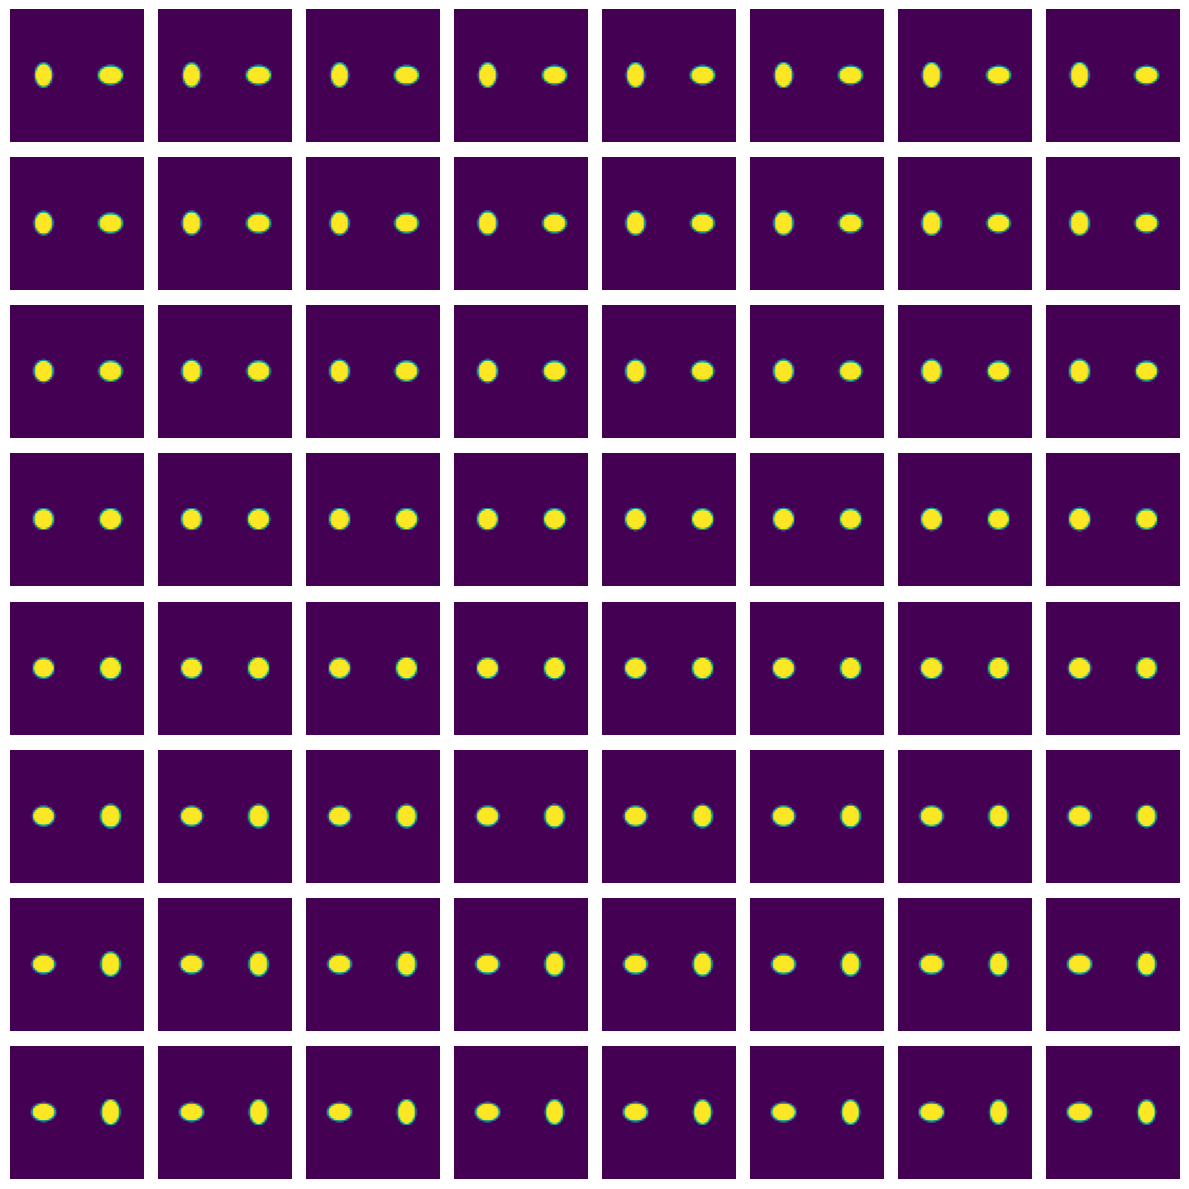

In [2]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    filename="data/two_ellipses_rad0d25/sample_{:03d}.mat".format(i)
    datSamp=aux.importMeasure(filename,totalMass=1.,keepZero=False)
    fig.add_subplot(8,8,i+1)
    plt.imshow(datSamp[0])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Principal component analysis in tangent space: W and HK

In [3]:
# load reference measure, here we just take Euclidean mean
datRef=aux.importMeasure("data/two_ellipses_rad0d25/mean.mat",totalMass=1.,keepZero=False)
muRef=datRef[1]
posRef=datRef[2].astype(np.double)
res=datRef[3]

In [4]:
params={}
params["setup_HKScale"]=5

In [5]:
loadedW=np.load("data/two_ellipses_rad0d25/tan_dataW2.npz")
distListW=loadedW['distList']
tangentListW=loadedW['tanList']

loadedHK=np.load("data/two_ellipses_rad0d25/tan_dataHK_5.npz")
distListHK=loadedHK['distList']
tangentListHK=(loadedHK['tanListV'],loadedHK['tanListAlpha'])

In [6]:
# Generate W-2 linear embedding of ellipses data w.r.t. muRef

embW=LinOT.LinW2Embedding(muRef=muRef,posRef=posRef)
embW.addSamples(tangentListW)

# Re-center the embedding around its mean
embW.centerSamples()

# check if shape makes sense:
# 64 samples
# reference measure: 244 pts
# on each point have dim=2 velocity components
# so get 2*244=488
print(embW.samples.shape)

(64, 488)


In [7]:
# Generate W-2 linear embedding of ellipses data w.r.t. muRef

embHK=LinOT.LinHKEmbedding(muRef=muRef,posRef=posRef,kappa=params['setup_HKScale'])
embHK.addSamples(tangentListHK)

# Re-center the embedding around its mean
embHK.centerSamples()

# check if shape makes sense:
# 64 samples
# reference measure: 244 pts
# on each point have dim=2 velocity components + dim=1 mass component
# so get 3*244=732
print(embHK.samples.shape)

(64, 732)


In [8]:
embW.performPCA()
embHK.performPCA()

eigvalW=embW.pca_var
eigvecW=embW.pca_vec


eigvalHK=embHK.pca_var
eigvecHK=embHK.pca_vec

In [9]:
# coordinates of samples in PCA bases
coefW=embW.pca_coords
coefHK=embHK.pca_coords

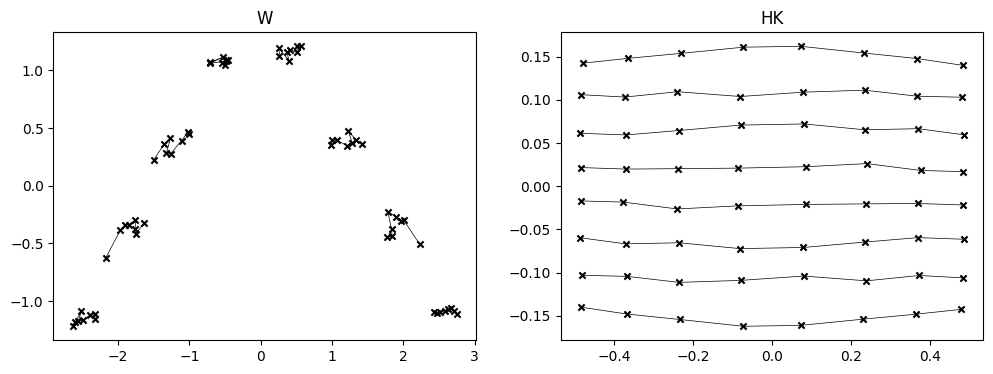

In [10]:
# show coordinates in PCA basis, first two modes
# connect samples with same elongation parameter, but different mass params with a line
fig=plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
plt.title("W")
for i in range(8):
    plt.plot(coefW[i::8,0],coefW[i::8,1],c="k",lw=0.5)
plt.scatter(coefW[:,0],coefW[:,1],c="k",s=20,marker="x")

fig.add_subplot(1,2,2)
plt.title("HK")
for i in range(8):
    plt.plot(coefHK[i::8,0],coefHK[i::8,1],c="k",lw=0.5)
plt.scatter(coefHK[:,0],coefHK[:,1],c="k",s=20,marker="x")

plt.show()

(10, 64, 64)


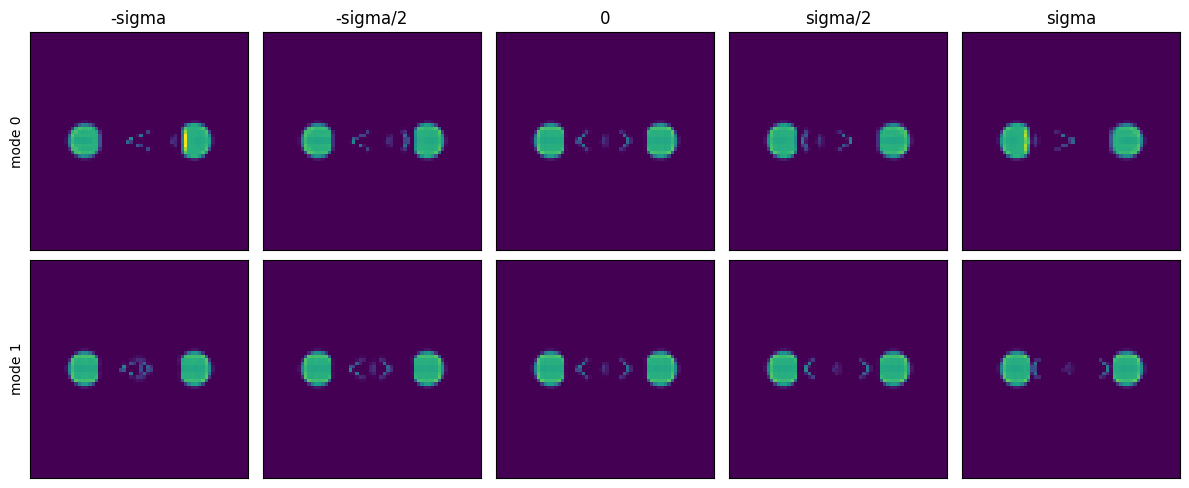

In [11]:
# shoot along eigenmodes of W embedding
titleList=["-sigma","-sigma/2","0","sigma/2","sigma"]
rowTitles=["mode 0", "mode 1"]

pcaBasis=np.identity(2)

imgList=[]
# generate all images in advance
for i in range(2):
    # how to shoot? take sqrt of corresponding eigenvalue
    scale=1*eigvalW[i]**0.5
    # how many pictures
    nPic=5
    # "unflatten" eigenvector
    shooting=embW.expPCA(pcaBasis[i], np.linspace(-scale,scale,nPic))
    
    for j in range(5):
        muExp,TExp=shooting[j]
        img=aux.rasterizePointCloud2d(muExp,TExp,res)
        imgList.append(img)
imgList=np.array(imgList)
print(imgList.shape)
imgList/=np.max(imgList)
imgList=(cm.viridis(imgList)[:,:,:,:3]*255).astype(np.uint8)

ShowImageArray(imgList,nCols=5,figWidth=12/5,figHeight=5/5,rowTitles=rowTitles,colTitles=titleList,\
        scaleMode="common",vmax=None,vmin=None,show=True)

(10, 64, 64)


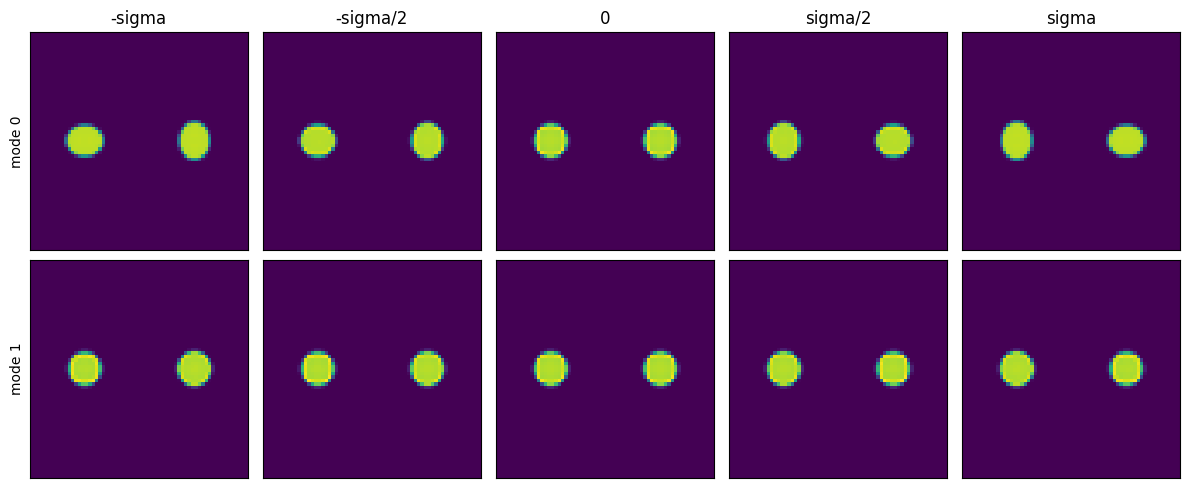

In [12]:
# shoot along eigenmodes of W embedding
titleList=["-sigma","-sigma/2","0","sigma/2","sigma"]
rowTitles=["mode 0", "mode 1"]


imgList=[]
# generate all images in advance
for i in range(2):
    # how to shoot? take sqrt of corresponding eigenvalue
    scale=1*eigvalHK[i]**0.5
    # how many pictures
    nPic=5
    # "unflatten" eigenvector
    shooting=embHK.expPCA(pcaBasis[i], np.linspace(-scale,scale,nPic))
    
    for j in range(5):
        muExp,TExp=shooting[j]
        img=aux.rasterizePointCloud2d(muExp,TExp,res)
        imgList.append(img)
imgList=np.array(imgList)
print(imgList.shape)
imgList/=np.max(imgList)
imgList=(cm.viridis(imgList)[:,:,:,:3]*255).astype(np.uint8)

ShowImageArray(imgList,nCols=5,figWidth=12/5,figHeight=5/5,rowTitles=rowTitles,colTitles=titleList,\
        scaleMode="common",vmax=None,vmin=None,show=True)

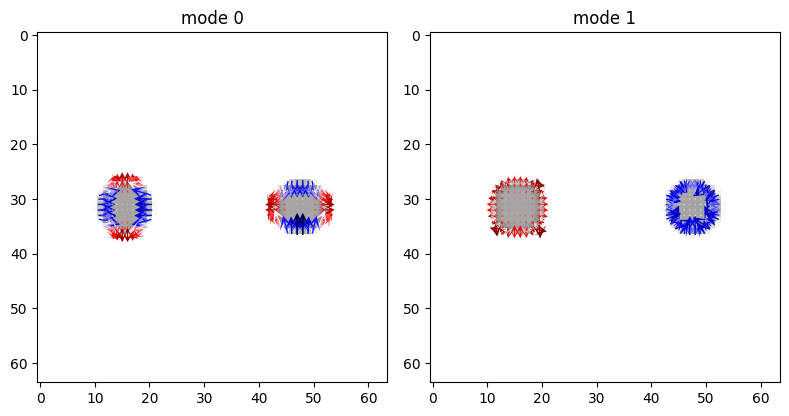

In [13]:
# quiver plot for HK modes

# first, obtain linearized mean
(muExp,TExp)=embHK.getMeanExp()
img=aux.rasterizePointCloud2d(muExp,TExp,res)



#img=img.transpose((1,0))
img/=np.max(img)
img*=0.5
img=cm.Greys(img)

# extract tangent modes

velList,alphaList=embHK.convertPCAToRaw(pcaBasis)

# normalize for colorization
alphaList=np.array(alphaList)
alphaList-=np.min(alphaList)
alphaList/=np.max(alphaList)
    
fig=plt.figure(figsize=(8,4))
for i in range(2):
    vel=velList[i]
    alpha=alphaList[i]
    
    colAlpha=cm.seismic(alpha)

    fig.add_subplot(1,2,i+1)
    plt.imshow(img)
    
    plt.quiver(TExp[:,1],TExp[:,0],vel[:,1],vel[:,0],color=colAlpha,angles="xy",units="xy",\
            scale=params["setup_HKScale"]/10,headwidth=10,headlength=10)

    #plt.axis("off")
    plt.title("mode {:d}".format(i))
    
plt.tight_layout()
plt.show()
